# Damped-Local-Trend(DLT) Example

In [1]:
import pandas as pd
import numpy as np
from orbit.dlt import DLT
from orbit.utils.plot import plot_predicted_data
from orbit.utils.plot import plot_predicted_components

## Data

In [ ]:
DATA_FILE = "./data/example_retail_sales.csv"

In [3]:
raw_df = pd.read_csv(DATA_FILE, parse_dates=['ds'])

In [4]:
raw_df.dtypes

ds    datetime64[ns]
y              int64
dtype: object

In [5]:
raw_df.head(5)

,ds,y
0,1992-01-01,146376
1,1992-02-01,147079
2,1992-03-01,159336
3,1992-04-01,163669
4,1992-05-01,170068


### Train / Test Split

In [6]:
df=raw_df.copy()
test_size=12
train_df=df[:-test_size]
test_df=df[-test_size:]

## MAP Fit and Predict

In [84]:
dlt_map=DLT(
    response_col='y',
    date_col='ds',
    seasonality=12,
    seed=8888,
    predict_method='map',
#     sample_method='mcmc',
    use_log_global_trend=True,
    is_multiplicative=True,
)

In [92]:
dlt_map2=DLT(
    response_col='y',
    date_col='ds',
    seasonality=12,
    seed=8888,
    predict_method='map',
#     sample_method='mcmc',
    use_log_global_trend=False,
    is_multiplicative=True,
)

In [93]:
dlt_map.fit(df=train_df)
dlt_map2.fit(df=train_df)

In [103]:
print(dlt_map.aggregated_posteriors['map']['gl'],
dlt_map.aggregated_posteriors['map']['gb'],
dlt_map2.aggregated_posteriors['map']['gl'],
dlt_map2.aggregated_posteriors['map']['gb'])

[0.00453747] [0.00646431] [-0.8442943] [0.00396884]


In [95]:
predicted_df = dlt_map2.predict(df=df, decompose=True)

In [96]:
predicted_df.head(5)

,ds,prediction,trend,seasonality,regression
0,1992-01-01,146376.000000,164069.391630,0.892159,1.0
1,1992-02-01,145654.013413,164721.850167,0.884242,1.0
2,1992-03-01,164591.013847,166028.287650,0.991343,1.0
3,1992-04-01,163190.351835,164537.816417,0.991811,1.0
4,1992-05-01,170550.900427,165339.347281,1.031520,1.0


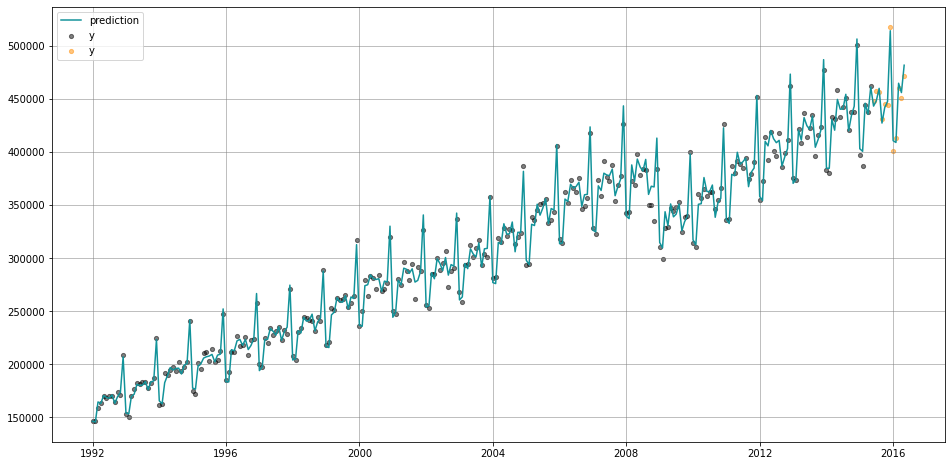

In [97]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=dlt_map.date_col, actual_col=dlt_map.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

In [98]:
from datetime import timedelta

In [99]:
num_periods = 104
freq = 7
last_dt = (df["ds"].dt.to_pydatetime())[-1]
dts = [last_dt + timedelta(days=x * freq) for x in range(1, num_periods + 1)]
future_df = pd.DataFrame(dts, columns=["ds"])

In [100]:
predicted_df = dlt_map.predict(df=future_df, decompose=True)
predicted_df2 = dlt_map2.predict(df=future_df, decompose=True)

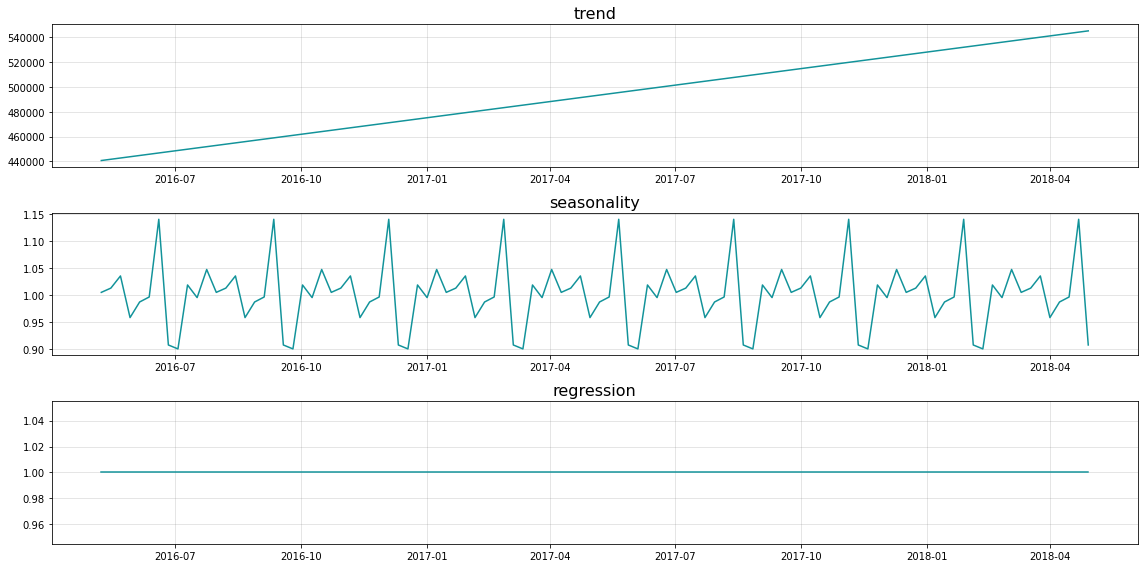

In [101]:
plot_predicted_components(predicted_df=predicted_df, date_col='ds')

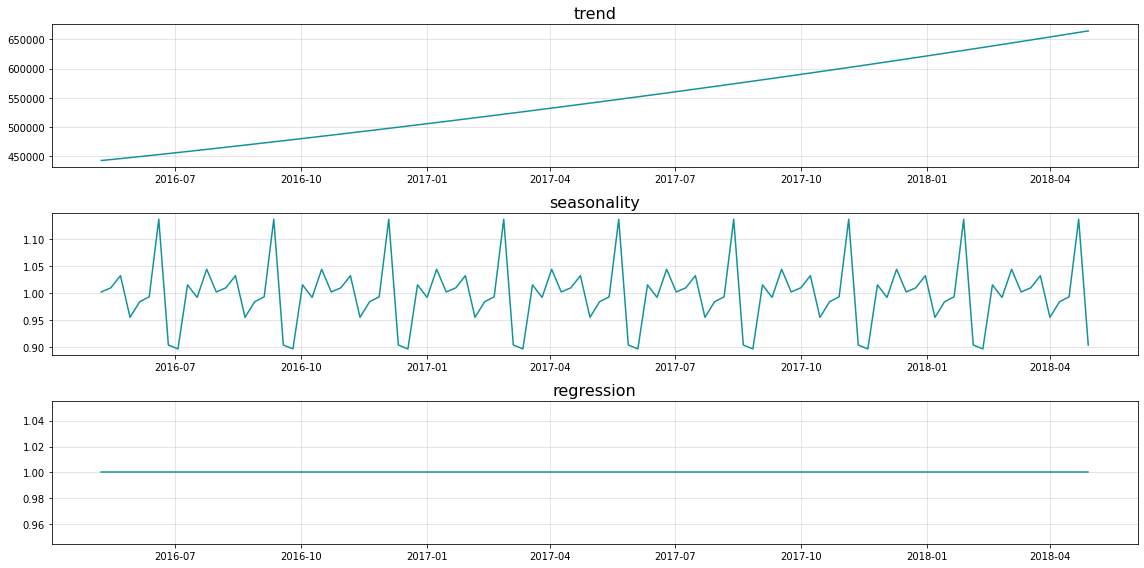

In [102]:
plot_predicted_components(predicted_df=predicted_df2, date_col='ds')

## MCMC Fit and Predict

In [12]:
dlt_mcmc = DLT(
    response_col='claims',
    date_col='week',
    seasonality=52,
    num_warmup=4000, 
    num_sample=500,
    sample_method='mcmc',
    predict_method='full',
    n_bootstrap_draws=500
)

In [13]:
dlt_mcmc.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [31]:
predicted_df = dlt_mcmc.predict(df=test_df)

In [32]:
predicted_df.tail(5)

,week,5,50,95
47,2018-05-27,182959.235157,205277.320679,230707.264288
48,2018-06-03,171366.177245,193755.147616,220681.131852
49,2018-06-10,189316.890799,212151.798585,236906.419611
50,2018-06-17,181551.858196,205944.217998,231289.589058
51,2018-06-24,191795.923139,215442.350652,242497.866588


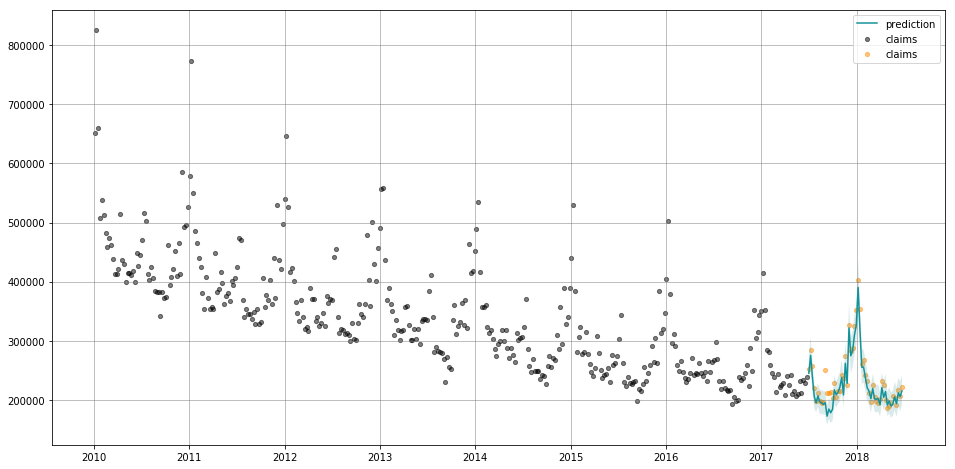

In [33]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=dlt_mcmc.date_col, actual_col=dlt_mcmc.response_col, pred_col=50, 
                    pred_quantiles_col=[5,95], test_actual_df=test_df)

## Mean Fit

In [34]:
dlt_mean=DLT(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seed=8888,
    predict_method='mean'
)

In [35]:
dlt_mean.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [36]:
predicted_df = dlt_mean.predict(df=test_df, decompose=True)

In [37]:
predicted_df.head(5)

,week,prediction,trend,seasonality,regression
0,2017-07-02,245993.880328,232480.643676,1.058126,1.0
1,2017-07-09,276591.932588,232049.238399,1.191954,1.0
2,2017-07-16,237953.290205,231615.511792,1.027363,1.0
3,2017-07-23,205792.490785,231180.103071,0.890183,1.0
4,2017-07-30,195892.016856,230743.522395,0.848960,1.0


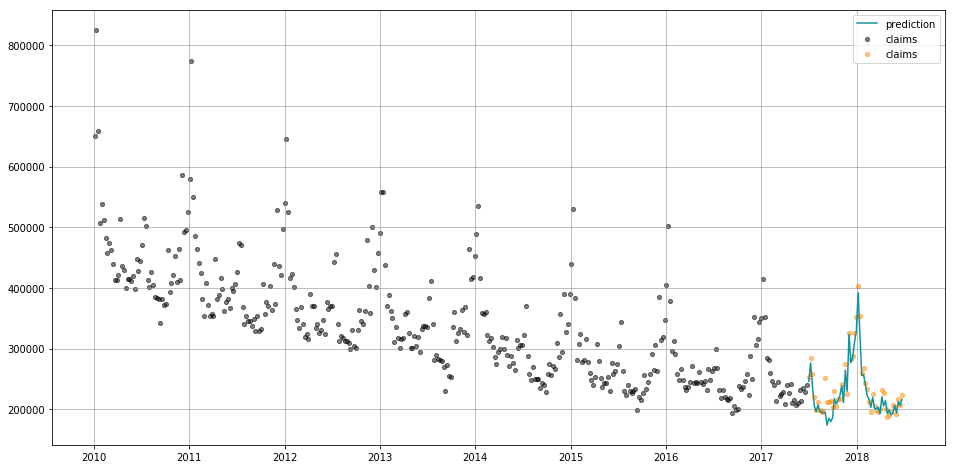

In [38]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=dlt_mean.date_col, actual_col=dlt_mean.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

## Fit with Regressors & Predict with Decomp

### Fit with Regressors

In [39]:
dlt_reg_map=DLT(
    response_col='claims',
    regressor_col=['trend.unemploy', 'trend.filling'],
    date_col='week',
    seasonality=52,
    seed=8888,
    predict_method='map'
)

In [40]:
dlt_reg_map.fit(df=train_df)

### Decompose Prediction

We can use `decompose=True` to decompose prediction into `trend`, `seasonality` and `regression` components. This command only works with point estimate.

In [44]:
# make prediction of past and future
predicted_df = dlt_reg_map.predict(df=df, decompose=True)
predicted_df.head(5)

,week,prediction,trend,seasonality,regression
0,2010-01-03,651215.000000,491257.678942,1.364563,0.971452
1,2010-01-10,827336.022907,490256.284730,1.713657,0.984770
2,2010-01-17,651545.442510,489244.730825,1.366008,0.974911
3,2010-01-24,517206.291336,488324.241011,1.076283,0.984077
4,2010-01-31,532516.933454,487224.172869,1.119778,0.976051


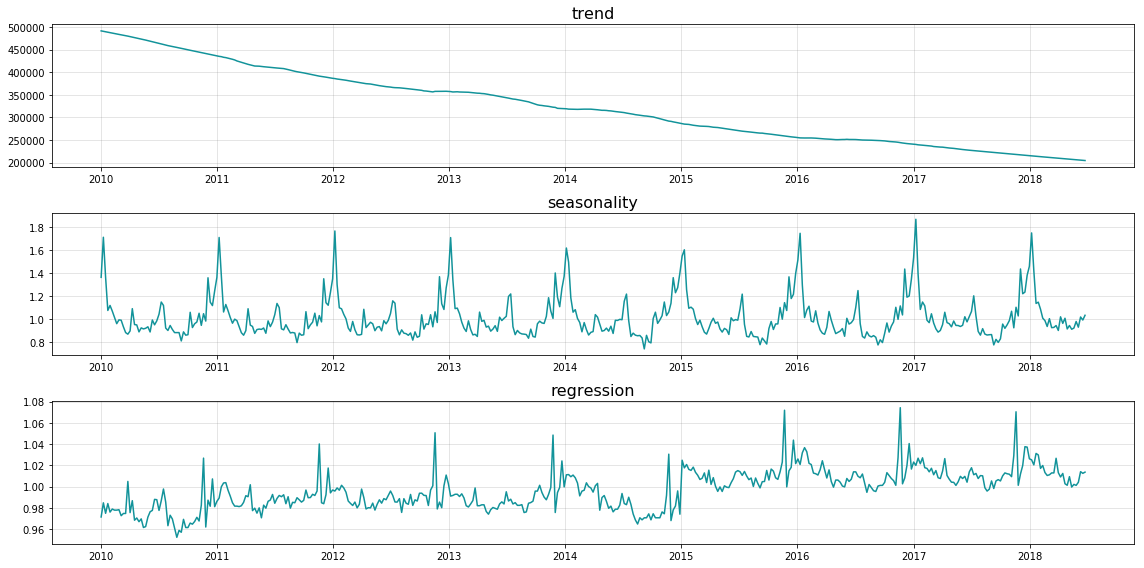

In [45]:
plot_predicted_components(predicted_df=predicted_df, date_col='week')